### Import data and create figures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import csv
import numpy as np
import pandas as pd
import scipy.stats as st
from copy import deepcopy
from importlib import reload

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

from colorsys import hsv_to_rgb
import mplot as mp

# Plot conventions

def cm2inch(x): return float(x)/2.54
single_column   = cm2inch(8.5)  # Nature: 8.9cm, PNAS: 8.7cm, Cell: 8.5cm
one_five_column = cm2inch(11.4) # PNAS & Cell: 11.4cm
double_column   = cm2inch(17.4) # Nature: 18.3cm, PNAS: 17.8cm, Cell: 17.4cm

goldr        = (1.0 + np.sqrt(5)) / 2.0
bkcolor      = '#252525'
altcolor     = '#3182bd'
fontfamily   = 'Arial' #'Helvetica'
sizeline     = 0.6
sizesublabel = 9
sizelabel    = 8#7
sizetick     = 7#6
ticklength   = 3
tickpad      = 3
axwidth      = 0.4

figprops = {
    'transparent' : True,
    'bbox_inches' : 'tight'
    }

def_barprops = {
    'lw'          : sizeline/2,
    'width'       : 0.25,
    'edgecolor'   : bkcolor,
    'align'       : 'center', #other option: edge
    'orientation' : 'vertical'
    }

def_histprops = {
    'histtype'    : 'bar',
    'lw'          : sizeline/2,
    'rwidth'      : 0.8,
    'ls'          : 'solid',
    'edgecolor'   : bkcolor,
    'alpha'       : 0.5
    }

def_lineprops = {
    'lw' : sizeline, 
    'ls' : '-'
    }

def_labelprops = {
    'family' : fontfamily,
    'size'   : sizelabel,
    'color'  : bkcolor
    }

def_sublabelprops = {
    'family' : fontfamily,
    'size'   : sizesublabel,
    'weight' : 'bold',
    'ha'     : 'center',
    'va'     : 'center',
    'color'  : 'k'
    }

def_ticklabelprops = {
    'family' : fontfamily,
    'size'   : sizetick,
    'color'  : bkcolor
    }

def_tickprops = {
    'length'    : ticklength,
    'width'     : axwidth/2,
    'pad'       : tickpad,
    'axis'      : 'both',
    'direction' : 'out',
    'colors'    : bkcolor,
    'bottom'    : True,
    'left'      : True,
    'top'       : False,
    'right'     : False
    }

def_minortickprops = {
    'length'    : ticklength-1.25,
    'width'     : axwidth/2,
    'axis'      : 'both',
    'direction' : 'out',
    'which'     : 'minor',
    'color'     : bkcolor
    }

def_axprops = {
    'linewidth' : axwidth,
    'linestyle' : '-',
    'color'     : bkcolor
    }

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'mathtext.default' : 'regular'}
plot.rcParams.update(params)

### Important functions

In [3]:
def getdE(o=3.0, mu=1.9, sigma=0.5):
    """ Return a random (change in) binding energy following a shifted log-normal distribution. """
    return o - np.exp(np.random.normal(mu, sigma))
    
def getE(Ec, Ev, Q, l=0.9):
    """ Return binding energy given raw binding energies with conserved and variable regions, and flexibility. """
    E0 = 4.
    return (Q * ((l * Ec) + ((1. - l) * Ev))) + ((1. - Q) * E0)

### Parameters for alternate $\lambda$

In [ ]:
# High Ec

p_mut        = 0.20                             # probability of mutation per division round
p_CDR        = 0.85                             # probability of mutation in the CDR region
p_CDR_lethal = 0.30                             # probability that a CDR mutation is lethal
p_CDR_silent = 0.50                             # probability that a CDR mutation is silent
p_CDR_affect = 1. - p_CDR_lethal - p_CDR_silent # probability that a CDR mutation affects affinity
p_var        = 0.20                             # probability that a CDR mutation affects the variable region
p_cons       = 1.0 - p_var                      # probability that a CDR mutation affects the constant region
p_FR_lethal  = 0.80                             # probability that a framework (FR) mutation is lethal
p_FR_silent  = 0.                               # probability that a FR mutation is silent
p_FR_affect  = 1. - p_FR_lethal - p_FR_silent   # probability that a FR mutation affects affinity

nb_Ag        = 5               # number of antigens
conc         = 1.08            # antigen concentration
energy_scale = 0.07            # inverse temperature
E0           = 4.00            # mean binding energy for mixing with flexibility
sigmaQ       = 0.08            # standard deviation for changes in flexibility with FR mutation
help_cutoff  = 0.70            # only B cells in the top (help_cutoff) fraction of binders receive T cell help
p_recycle    = 0.70            # probability that a B cell is recycled
p_exit       = 1. - p_recycle  # probability that a B cell exits the GC

mu     =  1.9   # lognormal mean
sigma  =  0.5   # lognormal standard deviation
corr   =  0.0   # correlation between antigen variable regions
o      =  3.0   # lognormal offset

# Low Ec

p_mut        = 0.20                             # probability of mutation per division round
p_CDR        = 0.85                             # probability of mutation in the CDR region
p_CDR_lethal = 0.30                             # probability that a CDR mutation is lethal
p_CDR_silent = 0.50                             # probability that a CDR mutation is silent
p_CDR_affect = 1. - p_CDR_lethal - p_CDR_silent # probability that a CDR mutation affects affinity
p_var        = 0.20                             # probability that a CDR mutation affects the variable region
p_cons       = 1.0 - p_var                      # probability that a CDR mutation affects the constant region
p_FR_lethal  = 0.80                             # probability that a framework (FR) mutation is lethal
p_FR_silent  = 0.                               # probability that a FR mutation is silent
p_FR_affect  = 1. - p_FR_lethal - p_FR_silent   # probability that a FR mutation affects affinity

nb_Ag        = 5               # number of antigens
conc         = 1.21            # antigen concentration
energy_scale = 0.07            # inverse temperature
E0           = 4.00            # mean binding energy for mixing with flexibility
sigmaQ       = 0.08            # standard deviation for changes in flexibility with FR mutation
help_cutoff  = 0.70            # only B cells in the top (help_cutoff) fraction of binders receive T cell help
p_recycle    = 0.70            # probability that a B cell is recycled
p_exit       = 1. - p_recycle  # probability that a B cell exits the GC

mu     =  1.9   # lognormal mean
sigma  =  0.5   # lognormal standard deviation
corr   =  0.0   # correlation between antigen variable regions
o      =  3.0   # lognormal offset

### Compare bnAb IC50 values

In [18]:
df = pd.read_csv('ab_data/ic50_summary.csv')

IC50  = {'3BNC60' : [], 'CH103' : [], 'PGT121' : []}
bnAbs = ['3BNC60', 'CH103', 'PGT121']

for i in range(len(df)):
    for ab in bnAbs:
        IC50_val = df.iloc[i][ab+'_IC50']
        if IC50_val[0]=='>': IC50_val = IC50_val[1:]
        IC50[ab].append(float(IC50_val))

print('      \t%s' % ('\t'.join(bnAbs)))
print('mean  \t%s' % ('\t'.join(['%.3f' %   np.mean(IC50[ab]) for ab in bnAbs])))
print('median\t%s' % ('\t'.join(['%.3f' % np.median(IC50[ab]) for ab in bnAbs])))

aff_range = np.logspace(-4, 2, num=50, endpoint=True)
y         = [[np.sum(IC50[ab]<x)/float(len(IC50[ab])) for x in aff_range] for ab in bnAbs]
x         = [aff_range                                                    for ab in bnAbs]

w     = single_column
goldh = (1.0*w)/goldr
fig   = plot.figure(figsize=(w, goldh))
ax    = plot.subplot(111)

legendprops = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                'prop' : {'size' : sizelabel}, 'ncol' : 1 }
colors      = ['#2171b5', '#6baed6', '#bdd7e7']
    
pprops = { 'xlim'   : [ 1.0e-4, 1.0e2],
           'xticks' : [ 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0, 1.0e1, 1.0e2],
           'logx'   : True,
           'ylim'   : [ 0, 1],
           'nudgey' : 1.1,
           'xlabel' : 'IC50',
           'ylabel' : 'Cumulative distribution',
           'legend' : bnAbs,
           'legendprops' : legendprops }

mp.plot(type='line', ax=ax, x=x, y=y, colors=colors, **pprops)

# Save data
plot.savefig('figures/IC50s.pdf', **figprops)
plot.close(fig)

print('Done.')

      	3BNC60	CH103	PGT121
mean  	2.556	7.265	17.673
median	0.150	0.946	2.970
Done.


### Figure: Population trajectories of successful and unsusccessful GCs

In [6]:
# Load the data here -- single antigen case

# df    = pd.read_csv(        '10k-output-total.csv', memory_map=True)
# dfLC  = pd.read_csv('10k-output-largest-clone.csv', memory_map=True)
# dfMem = pd.read_csv(       '10k-output-memory.csv', memory_map=True)

# df    = pd.read_csv(        '10k-noQ-output-total.csv', memory_map=True)
# dfLC  = pd.read_csv('10k-noQ-output-largest-clone.csv', memory_map=True)
# dfMem = pd.read_csv(       '10k-noQ-output-memory.csv', memory_map=True)

# df    = pd.read_csv(        '10k-l0.8-hiEc-output-total.csv', memory_map=True)
# dfLC  = pd.read_csv('10k-l0.8-hiEc-output-largest-clone.csv', memory_map=True)
# dfMem = pd.read_csv(       '10k-l0.8-hiEc-output-memory.csv', memory_map=True)

# df    = pd.read_csv(        '10k-l0.8-loEc-output-total.csv', memory_map=True)
# dfLC  = pd.read_csv('10k-l0.8-loEc-output-largest-clone.csv', memory_map=True)
# dfMem = pd.read_csv(       '10k-l0.8-loEc-output-memory.csv', memory_map=True)

#df    = pd.read_csv(        '1k-7f-output-total.csv', memory_map=True)
#dfLC  = pd.read_csv('1k-7f-output-largest-clone.csv', memory_map=True)
#dfMem = pd.read_csv(       '1k-7f-output-memory.csv', memory_map=True)

df    = pd.read_csv(        'output-total.csv', memory_map=True)
dfLC  = pd.read_csv('output-largest-clone.csv', memory_map=True)
dfMem = pd.read_csv(       'output-memory.csv', memory_map=True)

nTrials = 100
finalE  = []
finalEM = []
nMut    = []

for t in range(nTrials):
    dfT = dfMem[dfMem['trial']==t]
    if len(dfT)>0:
        idx = np.argmax(np.array(dfT['number']))
        nMut.append(dfT.iloc[idx].mutations)
        tempEc = dfT.iloc[idx].Ec
        tempEv = dfT.iloc[idx].Ev0
        tempQ  = dfT.iloc[idx].Q
        finalE.append(getE(tempEc, tempEv, tempQ))
        
#         tempEc = np.array(dfT.Ec)
#         tempEv = np.array(dfT.Ev0)
#         tempQ  = np.array(dfT.Q)
#         finalEM.append(np.max(getE(tempEc, tempEv, tempQ)))

Plotting GC trajectories...
Plotting supplementary info...


/Users/jlouveau/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


FileNotFoundError: [Errno 2] No such file or directory: 'figures/7f-population-trajectories.pdf'

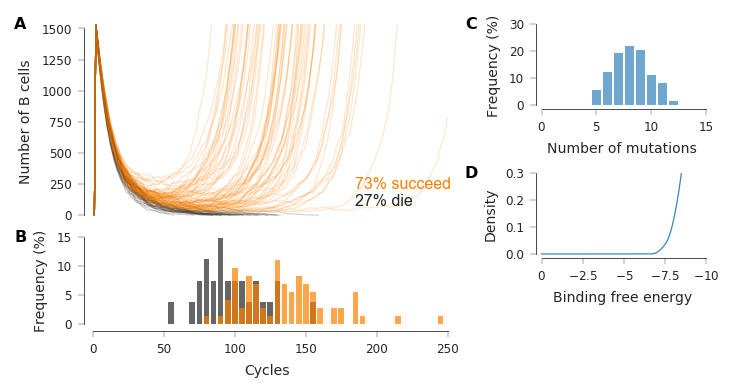

In [7]:
# Plot the figure

nTrials = 100
plotCut = 100  # number of actual lines to plot
nSurv   = 0
hSurv   = []
hDie    = []

#w     = single_column
#goldh = (1.2*w)/goldr
#fig   = plot.figure(figsize=(w, goldh))
#gs    = gridspec.GridSpec(2, 1, width_ratios=[1.00], height_ratios=[1.00,0.4])
#ax1   = plot.subplot(gs[0, 0]) # trajectories
#ax2   = plot.subplot(gs[1, 0]) # end cycle histogram

w     = one_five_column
goldh = (1.0*w)/goldr
fig   = plot.figure(figsize=(w, goldh))
# gs    = gridspec.GridSpec(3, 2, width_ratios=[1.00,0.50], height_ratios=[1.0,1.0,1.0])
# ax1   = plot.subplot(gs[:2, 0]) # trajectories
# ax2   = plot.subplot(gs[ 2, 0]) # end cycle histogram
# ax3   = plot.subplot(gs[ 0, 1]) # kde - mutations
# ax4   = plot.subplot(gs[ 1, 1]) # kde - final energy
gs1   = gridspec.GridSpec(3, 1, width_ratios=[1.00], height_ratios=[1.0,1.0,1.0])
gs1.update(left=0.02, right=0.58, hspace=0.2)
ax1   = plot.subplot(gs1[:2, 0]) # trajectories
ax2   = plot.subplot(gs1[ 2, 0]) # end cycle histogram
gs2   = gridspec.GridSpec(2, 1, width_ratios=[1.00], height_ratios=[1.0,1.0])
gs2.update(left=0.72, right=0.98, bottom=0.3, hspace=0.8)
ax3   = plot.subplot(gs2[ 0, 0]) # kde - mutations
ax4   = plot.subplot(gs2[ 1, 0]) # kde - final energy


# PART 1: Trajectories

print('Plotting GC trajectories...')

legendprops = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                'prop' : {'size' : sizelabel}, 'ncol' : 1 }
lineprops   = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 0.2 }
cSurv       = '#FF7F00'
cDie        = bkcolor
    
pprops = { 'xlim'      : [ 0, 250],
           'xticks'    : [],
           'ylim'      : [ 0, 1536],
           'yticks'    : [ 0,  250, 500, 750, 1000, 1250, 1500],
           'ylabel'    : 'Number of B cells',
           'plotprops' : lineprops,
           'hide'      : ['bottom'],
           'sublabel'  : 'A',
           'sublabelcoords' : [-0.18, 1.00] }

for t in range(nTrials):
    dfT  = df[df['trial']==t]
    x, y = np.array(dfT['cycle']), np.array(dfT['number recycled'])
    if y[-1]>0: 
        nSurv += 1
        hSurv.append(x[-1])
        if t<plotCut: mp.line(ax=ax1, x=[x], y=[y], colors=[cSurv], **pprops)
    else:
        hDie.append(x[-1])
        if t<plotCut: mp.line(ax=ax1, x=[x], y=[y], colors=[cDie],  **pprops)


offPlot    = [[-10,-10],[-10,-10]]
survString = '%d%%' % np.round(float(nSurv)/float(nTrials) * 100) + ' succeed'
dieString  = '%d%%' % np.round(100. - (float(nSurv)/float(nTrials) * 100)) + ' die'
ax1.text(185, 250, survString, ha='left', va='center', color=cSurv, family=fontfamily, size=sizelabel)
ax1.text(185, 110,  dieString, ha='left', va='center', color= cDie, family=fontfamily, size=sizelabel)
mp.plot(type='line', ax=ax1, x=offPlot, y=offPlot, colors=[cSurv,cDie], **pprops)


# PART 2: Histograms

print('Plotting supplementary info...')

histprops                = { 'histtype' : 'bar', 'lw' : sizeline/2, 'rwidth' : 0.8, 'ls' : 'solid', 'alpha' : 0.7,
                             'align' : 'left' }
pprops['hide']           = []
pprops['xlim']           = [ 0, 250]
pprops['xticks']         = [ 0,  50, 100, 150, 200, 250]
pprops['xaxy']           = 1
pprops['xlabel']         = 'Cycles'
pprops['ylim']           = [0, 0.15]
pprops['yticks']         = [0, 0.05, 0.10, 0.15]
pprops['yticklabels']    = ['0', '5', '10', '15']
pprops['ylabel']         = 'Frequency (%)'
pprops['plotprops']      = histprops
pprops['sublabel']       = 'B'
pprops['sublabelcoords'] = [-0.18, 1.00]

mp.plot(type='hist', ax=ax2, x=[hSurv, hDie], colors=[cSurv, cDie], **pprops)


# PART 3: KDEs
cKDE = '#3182bd'

pprops['plotprops']      = histprops
pprops['bins']           = np.arange(0,15+1,1)
pprops['xlim']           = [ 0, 15]
pprops['xticks']         = [ 0, 5, 10, 15]
pprops['xlabel']         = 'Number of mutations'
pprops['ylim']           = [0, 0.30]
pprops['yticks']         = [0, 0.10, 0.20, 0.30]
pprops['yticklabels']    = ['0', '10', '20', '30']
pprops['ylabel']         = 'Frequency (%)'
pprops['sublabel']       = 'C'
pprops['sublabelcoords'] = [-0.40, 1.00]

mp.plot(type='hist', ax=ax3, x=[nMut], colors=[cKDE], **pprops)

del pprops['yticklabels']
pprops['plotprops']      = def_lineprops
pprops['xlim']           = [ 0, 10]
pprops['xticks']         = [ 0, 2.5, 5, 7.5, 10]
pprops['xticklabels']    = [r'$0$', r'$-2.5$', r'$-5$', r'$-7.5$', r'$-10$']
pprops['xlabel']         = 'Binding free energy'
pprops['ylim']           = [0, 0.3]
pprops['yticks']         = [0, 0.1, 0.2, 0.3]
pprops['ylabel']         = 'Density'
pprops['sublabel']       = 'D'
pprops['sublabelcoords'] = [-0.40, 1.00]

mp.plot(type='kde', ax=ax4, x=[finalE], colors=[cKDE], **pprops)


# Save data
plot.savefig('figures/7f-population-trajectories.pdf', **figprops)
plot.close(fig)

print('Done.')

### Figure: Breadth comparisons at different binding energy cutoffs

In [54]:
# Create alternate "test panel" of 100 sequences with different Ev

nTrials   = 10000
nPanel    = 100
#testPanel = np.array([getdE(o=0, mu=3.0, sigma=2.5 * 0.5) for i in range(nPanel)]) # label super
#testPanel = np.array([getdE(o=0, mu=1.9, sigma=0.5) for i in range(nPanel)]) # label super2
testPanel = np.array([getdE(o=0, mu=3.0, sigma=1.0) for i in range(nPanel)]) # label super3

# Read through largest clone histories and output binding energies with the test panel

# fIn  = ['10000Trials_cluster_high_Ec/output-largest-clone.csv',
#         '10000Trials_cluster_low_Ec/output-largest-clone.csv']
# fOut = ['10k-hiEc-panel-breadth.csv', '10k-loEc-panel-breadth.csv']
# fIn  = ['10k-l0.8-hiEC-output-largest-clone.csv',
#         '10k-l0.8-loEC-output-largest-clone.csv']
# fOut = ['10k-l0.8-hiEc-panel-breadth.csv', 
#         '10k-l0.8-loEc-panel-breadth.csv']

fIn  = ['10000Trials_cluster_high_Ec/output-largest-clone.csv',
        '10000Trials_cluster_low_Ec/output-largest-clone.csv']
fOut = ['10k-hiEc-panel-super-breadth3.csv', '10k-loEc-panel-super-breadth3.csv']

for k in range(len(fIn)):
    if os.path.isfile(fOut[k]):
        continue
    else:
        f  = open(fOut[k], 'w')
        f.write('trial,generation,Q,Ec%s\n' % (''.join([',Ev%d' % (i+1) for i in range(nPanel)])))

        df = pd.read_csv(fIn[k], memory_map=True)

        for t in range(nTrials):
            trialDf = df[df.trial==t]

            if len(trialDf)==0: continue

            # Set starting binding energies with test panel

            panelEc = trialDf.iloc[0].Ec
            panelEv = deepcopy(testPanel)

            f.write('%d,%d,%lf,%lf' % (trialDf.iloc[0].trial,trialDf.iloc[0].generation,trialDf.iloc[0].Q,panelEc))
            for i in range(len(testPanel)): f.write(',%lf' % panelEv[i])
            f.write('\n')

            # Iterate over successive mutations and update binding energies

            for k in range(1,len(trialDf)):

                if trialDf.iloc[k].Q==trialDf.iloc[k-1].Q:
                #if trialDf.iloc[k].CDR_mutations>trialDf.iloc[k-1].CDR_mutations:
                    dEc = trialDf.iloc[k].Ec-trialDf.iloc[k-1].Ec
                    if dEc==0:
                        for i in range(len(testPanel)): panelEv[i] += getdE()
                    else: panelEc += dEc

                f.write('%d,%d,%lf,%lf' % (trialDf.iloc[k].trial,trialDf.iloc[k].generation,trialDf.iloc[k].Q,panelEc))
                for i in range(len(testPanel)): f.write(',%lf' % panelEv[i])
                f.write('\n')
                f.flush()

        f.close()

### Figure: Trajectories in the flexibility - binding energy space

In [ ]:
# dfLC  = pd.read_csv('10k-output-largest-clone.csv', memory_map=True)
# dfLC = dfLC.assign(n_fwr=pd.Series(np.zeros(len(dfLC))).values)
# dfLC = dfLC.assign(n_cdr=pd.Series(np.zeros(len(dfLC))).values)

# for i in range(1,len(dfLC)):
#     if dfLC.iloc[i].trial!=dfLC.iloc[i-1].trial: continue
#     if dfLC.iloc[i].Q==dfLC.iloc[i-1].Q: dfLC.set_value(i, 'n_fwr', dfLC.iloc[i-1].n_fwr+1)
#     else:                                dfLC.set_value(i, 'n_cdr', dfLC.iloc[i-1].n_cdr+1)

In [62]:
# Load the data here

dfHi = pd.read_csv('10000Trials_cluster_high_Ec/output-largest-clone.csv', memory_map=True)
dfLo = pd.read_csv('10000Trials_cluster_low_Ec/output-largest-clone.csv', memory_map=True)
        
dfHi.set_index(['trial'], inplace=True)
dfLo.set_index(['trial'], inplace=True)

genCut = [25, 150, 400]

xHi, yHi = [], []
xLo, yLo = [], []

lastdfHi = dfHi[dfHi['generation']==0]
lastdfLo = dfLo[dfLo['generation']==0]

for t in range(1,501):
    nextdfHi = dfHi[dfHi['generation']==t].combine_first(lastdfHi)
    lastdfHi = nextdfHi
    nextdfLo = dfLo[dfLo['generation']==t].combine_first(lastdfLo)
    lastdfLo = nextdfLo
    
    if t in genCut:
        xHi.append(np.array(nextdfHi['CDR_mutations']))
        yHi.append(np.array(nextdfHi['FR_mutations']))
        xLo.append(np.array(nextdfLo['CDR_mutations']))
        yLo.append(np.array(nextdfLo['FR_mutations']))

In [70]:
w     = double_column
goldh = (2.0/3.)*w
fig   = plot.figure(figsize=(w, goldh))

HiBox = [0.20, 0.98, 0.60, 0.90]
LoBox = [0.20, 0.98, 0.16, 0.46]

gsS   = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsS.update(left=HiBox[0], right=HiBox[1], bottom=0.93, top=1.0)
axS   = plot.subplot(gsS[ 0, 0])

gsHi  = gridspec.GridSpec(1, 3, width_ratios=[1.0, 1.0, 1.0])
gsHi.update(left=HiBox[0], right=HiBox[1], bottom=HiBox[2], top=HiBox[3], hspace=0.5, wspace=0.5)
gsLo  = gridspec.GridSpec(1, 3, width_ratios=[1.0, 1.0, 1.0])
gsLo.update(left=LoBox[0], right=LoBox[1], bottom=LoBox[2], top=LoBox[3], hspace=0.5, wspace=0.5)

axHi  = [plot.subplot(gsHi[i]) for i in range(len(genCut))]
axLo  = [plot.subplot(gsLo[i]) for i in range(len(genCut))]


# Overhead line

lineprops = { 'lw' : axwidth/2., 'ls' : '-', 'alpha' : 1.0 }
pprops    = { 'xlim' : [0, 1], 'xticks' : [], 'ylim' : [0, 1], 'yticks' : [], 
              'hide' : ['top','bottom','left','right'], 'plotprops' : lineprops }
tprops    = dict(color=bkcolor, family=fontfamily, size=sizelabel)
axS.text(3./6.-0.005, 1.0, 'Time (generations)', ha='center', va='top',    **tprops)
axS.text(1./6.-0.045, 0.3,              r'$25$', ha='center', va='center', **tprops)
axS.text(3./6.-0.005, 0.3,             r'$150$', ha='center', va='center', **tprops)
axS.text(5./6.+0.055, 0.3,             r'$400$', ha='center', va='center', **tprops)
ay = 0.05
axS.arrow(x=0, y=ay, dx=1, dy=0, head_width=0.25, head_length=0.025, overhang=0.5, fc=bkcolor,
             ec=None, lw=sizeline/2., clip_on=False, zorder=100)
mp.plot(type='line', ax=axS, x=[[0,1]], y=[[ay,ay]], colors=[bkcolor], **pprops)

# axS.text(3./6.-0.005, 1.0, 'Time (generations)', ha='center', va='top', 
#          color=bkcolor, family=fontfamily, size=sizelabel)
# axS.arrow(x=0, y=0.5, dx=1, dy=0, head_width=0.25, head_length=0.025, overhang=0.5, fc=bkcolor,
#           ec=None, lw=sizeline/2., clip_on=False)
# mp.plot(type='line', ax=axS, x=[[0,1]], y=[[0.5,0.5]], colors=[bkcolor], **pprops)


# Number of CDR/FWR mutations

print('Plotting number of mutations...')

levels = [0.02] + list(0.02 * np.logspace(1., 5., num=5, base=1.5))

legendprops  = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                 'prop' : {'size' : sizelabel}, 'ncol' : 1 }
contourprops = { 'cmap' : 'Greens', 'colors' : bkcolor, 'extend' : 'max', 'linewidths' : sizeline/2.,
                 'vmin' : 0.001, 'vmax' : 0.15 , 'levels' : levels }

dx     = 0.1
dy     = dx
cx     = np.arange(0., 12.+dx, dx)
cy     = np.arange(0., 12.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.9
sy = sx

pprops = { 'xlim'      : [ 0., 12.],
           'xticks'    : [ 0., 4., 8., 12.],
           'ylim'      : [ 0., 12.],
           'yticks'    : [ 0., 4., 8., 12.],
           'xlabel'    : 'CDR mutations',
           'ylabel'    : 'Framework mutations',
           'plotprops' : contourprops,
           #'axoffset'  : 0.1,
           #'plotprops' : scatterprops,
           'zorder'    : 10 }

for i in range(len(xHi)):
    zz = np.zeros(xx.shape)
    for k in range(len(xHi[i])):
        zz += np.exp(-((xHi[i][k]-xx)**2/sx**2) - ((yHi[i][k]-yy)**2/sy**2))
    zz /= float(len(xHi[i]))
    mp.plot(type='contour', ax=axHi[i], x=[xx], y=[yy], z=[zz], **pprops)

for i in range(len(xLo)):
    zz = np.zeros(xx.shape)
    for k in range(len(xLo[i])):
        zz += np.exp(-((xLo[i][k]-xx)**2/sx**2) - ((yLo[i][k]-yy)**2/sy**2))
    zz /= float(len(xLo[i]))
    mp.plot(type='contour', ax=axLo[i], x=[xx], y=[yy], z=[zz], **pprops)

# Background

axS.text(HiBox[0]-0.06, HiBox[3]-0.01, 'A', transform=fig.transFigure, **def_sublabelprops)
axS.text(LoBox[0]-0.06, LoBox[3]-0.01, 'B', transform=fig.transFigure, **def_sublabelprops)

cBG   = '#F5F5F5'
dx    = 0.08
dy    = 0.09
bgHi  = axS.axis()
recHi = matplotlib.patches.Rectangle(xy=(HiBox[0]-dx,HiBox[2]-dy), width=0.8+dx, height=HiBox[3]-HiBox[2]+(1.2*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recHi = axS.add_patch(recHi)

bgLo  = axS.axis()
recLo = matplotlib.patches.Rectangle(xy=(LoBox[0]-dx,LoBox[2]-dy), width=0.8+dx, height=LoBox[3]-LoBox[2]+(1.2*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recLo = axS.add_patch(recLo)
    
# Save data
plot.savefig('figures/mutations.pdf', dpi = 1000, 
              facecolor = fig.get_facecolor(), edgecolor=None, **figprops)
plot.close(fig)

print('Done.')

Plotting number of mutations...
Done.


In [55]:
# # Load data: Q vs Ec plot

# dfHi = pd.read_csv('10000Trials_cluster_high_Ec/output-largest-clone.csv', memory_map=True)
# dfLo = pd.read_csv( '10000Trials_cluster_low_Ec/output-largest-clone.csv', memory_map=True)

# # dfHi = pd.read_csv('10k-l0.8-hiEc-output-largest-clone.csv', memory_map=True)
# # dfLo = pd.read_csv('10k-l0.8-loEc-output-largest-clone.csv', memory_map=True)

# # dfHi = pd.read_csv('1k-7f-output-largest-clone.csv', memory_map=True)
# # dfLo = pd.read_csv('1k-7f-output-largest-clone.csv', memory_map=True)

# dfHi.set_index(['trial'], inplace=True)
# dfLo.set_index(['trial'], inplace=True)

# genCut = [25, 150, 400]

# xHi, yHi = [], []
# xLo, yLo = [], []

# lastdfHi = dfHi[dfHi['generation']==0]
# lastdfLo = dfLo[dfLo['generation']==0]

# for t in range(1,501):
#     nextdfHi = dfHi[dfHi['generation']==t].combine_first(lastdfHi)
#     lastdfHi = nextdfHi
#     nextdfLo = dfLo[dfLo['generation']==t].combine_first(lastdfLo)
#     lastdfLo = nextdfLo
    
#     if t in genCut:
#         xHi.append(np.array(nextdfHi['Ec']))
#         yHi.append(np.array(nextdfHi['Q']))
#         xLo.append(np.array(nextdfLo['Ec']))
#         yLo.append(np.array(nextdfLo['Q']))
        
# Load data: breadth plot

ECut = [3.0, 6.0, 9.0]

dfHi = pd.read_csv('10k-hiEc-panel-super-breadth3.csv', memory_map=True)
dfLo = pd.read_csv('10k-loEc-panel-super-breadth3.csv', memory_map=True)

# dfHi = pd.read_csv('10k-l0.8-hiEc-panel-super-breadth.csv', memory_map=True)
# dfLo = pd.read_csv('10k-l0.8-loEc-panel-super-breadth.csv', memory_map=True)

dfHi.set_index(['trial'], inplace=True)
dfLo.set_index(['trial'], inplace=True)

nPanel  = 100
bHi     = []
bLo     = []
bHiMed  = []
bLoMed  = []
bHiTrueMed  = []
bLoTrueMed  = []
EvLabel = ['Ev%d' % (i+1) for i in range(nPanel)]
denom   = float(nPanel)

lastdfHi = dfHi[dfHi['generation']==0]
lastdfLo = dfLo[dfLo['generation']==0]

for t in range(1,501):
    nextdfHi = dfHi[dfHi['generation']==t].combine_first(lastdfHi)
    lastdfHi = nextdfHi
    nextdfLo = dfLo[dfLo['generation']==t].combine_first(lastdfLo)
    lastdfLo = nextdfLo
    
    if t in genCut:
        tempQ  = np.array([ q * np.ones(nPanel) for  q in nextdfHi.Q])
        tempEc = np.array([ec * np.ones(nPanel) for ec in nextdfHi.Ec])
        EHi    = np.array(getE(tempEc, np.array(nextdfHi[EvLabel]), tempQ))
         
        tempQ  = np.array([ q * np.ones(nPanel) for  q in nextdfLo.Q])
        tempEc = np.array([ec * np.ones(nPanel) for ec in nextdfLo.Ec])
        ELo    = getE(tempEc, np.array(nextdfLo[EvLabel]), tempQ)
        
        bHi.append([[np.sum(E>c)/denom for E in EHi] for c in ECut])
        bLo.append([[np.sum(E>c)/denom for E in ELo] for c in ECut])
        
        bHiMed.append([np.mean(E) for E in EHi])
        bLoMed.append([np.mean(E) for E in ELo])
        
        bHiTrueMed.append([np.median(E) for E in EHi])
        bLoTrueMed.append([np.median(E) for E in ELo])
        
#         bHiMed.append([np.log(st.mstats.gmean(np.exp(E))) for E in EHi])
#         bLoMed.append([np.log(st.mstats.gmean(np.exp(E))) for E in ELo])

# for t in range(nTrials):
#     trialDfHi = dfHi[dfHi.trial==t]
#     trialDfLo = dfLo[dfLo.trial==t]
    
#     if len(trialDfHi>0):
#         tempQ  = np.array([ q * np.ones(nPanel) for  q in trialDfHi.Q])
#         tempEc = np.array([ec * np.ones(nPanel) for ec in trialDfHi.Ec])
#         EHi.append(getE(tempEc, np.array(trialDfHi[EvLabel]), testPanel, tempQ))
        
#     if len(trialDfLo>0):
#         tempQ  = np.array([ q * np.ones(nPanel) for  q in trialDfLo.Q])
#         tempEc = np.array([ec * np.ones(nPanel) for ec in trialDfLo.Ec])
#         ELo.append(getE(tempEc, np.array(trialDfLo[EvLabel]), testPanel, tempQ))


In [58]:
nTrials  = 10000
reload(mp)

w     = double_column
goldh = (3.3/3.0)*w
fig   = plot.figure(figsize=(w, goldh))

#LoBox = [0.20, 0.72, 0.53, 0.93]
#HiBox = [0.20, 0.72, 0.00, 0.40]
#LLBox = [0.82, 0.98, 0.68, 0.93]

HiBox = [0.20, 0.98, 0.61, 0.91]
LoBox = [0.20, 0.98, 0.23, 0.53]
LLBox = [0.10, 0.30, 0.00, 0.16]

gsS   = gridspec.GridSpec(1, 2, width_ratios=[1.0, 2.5], height_ratios=[1.0])
gsS.update(left=0, right=HiBox[1], bottom=0.93, top=1.0)
gsHiS = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsHiS.update(left=0.02, right=0.12, bottom=HiBox[2]+((HiBox[3]-HiBox[2])*0.5/1.3), top=HiBox[3])
gsLoS = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsLoS.update(left=0.02, right=0.12, bottom=LoBox[2]+((LoBox[3]-LoBox[2])*0.5/1.3), top=LoBox[3])
axS   = [plot.subplot(gsS[ 0, 1]), plot.subplot(gsHiS[ 0, 0]), plot.subplot(gsLoS[ 0, 0])]
axKey = plot.subplot(gsS[0, 0])

gsHi  = gridspec.GridSpec(2, 3, height_ratios=[1.0, 0.55], width_ratios=[1.0, 1.0, 1.0])
gsHi.update(left=HiBox[0], right=HiBox[1], bottom=HiBox[2], top=HiBox[3], hspace=0.2, wspace=0.2)
gsLo  = gridspec.GridSpec(2, 3, height_ratios=[1.0, 0.55], width_ratios=[1.0, 1.0, 1.0])
gsLo.update(left=LoBox[0], right=LoBox[1], bottom=LoBox[2], top=LoBox[3], hspace=0.2, wspace=0.2)
axHi  = [[plot.subplot(gsHi[0, i]), plot.subplot(gsHi[1, i])] for i in range(len(genCut))]
axLo  = [[plot.subplot(gsLo[0, i]), plot.subplot(gsLo[1, i])] for i in range(len(genCut))]

gsLL = gridspec.GridSpec(1, 1, height_ratios=[1.0], width_ratios=[1.0])
gsLL.update(left=LLBox[0], right=LLBox[1], bottom=LLBox[2], top=LLBox[3], hspace=0.4, wspace=0.1)
axLL = [plot.subplot(gsLL[0, 0])]

# Overhead line

lineprops = { 'lw' : axwidth/2., 'ls' : '-', 'alpha' : 1.0 }
pprops    = { 'xlim' : [0, 1], 'xticks' : [], 'ylim' : [0, 1], 'yticks' : [], 
              'hide' : ['top','bottom','left','right'], 'plotprops' : lineprops }
tprops    = dict(color=bkcolor, family=fontfamily, size=sizelabel)
axS[0].text(2.4/6.-0.005, 0.6, 'Time (generations)', ha='center', va='top',    **tprops)
axS[0].text(           0, 0.2,              r'$25$', ha='center', va='center', **tprops)
axS[0].text(2.4/6.-0.005, 0.2,             r'$150$', ha='center', va='center', **tprops)
axS[0].text(4.9/6.+0.015, 0.2,             r'$400$', ha='center', va='center', **tprops)
ay = 0.05
axS[0].arrow(x=-0.30, y=ay, dx=1+0.30, dy=0, head_width=0.25, head_length=0.025, overhang=0.5, fc=bkcolor,
             ec=None, lw=sizeline/2., clip_on=False, zorder=100)
mp.plot(type='line', ax=axS[0], x=[[0,1]], y=[[ay,ay]], colors=[bkcolor], **pprops)

# PART 1: densities

print('Plotting densities...')

legendprops  = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                 'prop' : {'size' : sizelabel}, 'ncol' : 1 }
contourprops = { 'cmap' : 'Oranges', 'colors' : bkcolor, 'vmin' : 0.001, 'vmax' : 0.10, 'extend' : 'max',
                 'linewidths' : sizeline/2., 'levels' : [0.001, 0.005, 0.015, 0.035, 0.075, 0.15]}

dx     = 0.1
dy     = dx * (1. / 16.)
cx     = np.arange(-2., 14.+dx, dx)
cy     = np.arange( 0.,  1.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.5
sy = sx * (1. / 16.)
    
pprops = { 'xlim'      : [-2., 14.],
           'xticks'    : [0.,  4.,  8., 12.],
           'xticklabels' : [r'$0$', r'$-4$', r'$-8$', r'$-12$'],
           'xminorticks' : [-2., 2., 6., 10., 14.],
           'ylim'      : [ 0., 1.],
           'yticks'    : [ 0., 0.25, 0.50, 0.75, 1.00],
           'xlabel'    : r'$E_c$',
           'ylabel'    : r'$Q$',
           'plotprops' : contourprops,
           #'axoffset'  : 0.1,
           'zorder'    : 10 }

r      = 1.
cprops = dict(width=r, height=r/14., ec='k', fc='w', alpha=1.0, zorder=100)

for i in range(len(genCut)):
    tempprops = pprops.copy()
    if i>0:
        del tempprops['ylabel']
        tempprops['yticks']   = []
        tempprops['hide']     = ['left']
    zz = np.zeros(xx.shape)
    for k in range(len(xHi[i])):
        zz += np.exp(-((xHi[i][k]-xx)**2/sx**2) - ((yHi[i][k]-yy)**2/sy**2))
    zz /= float(len(xHi[i]))
    mp.plot(type='contour', ax=axHi[i][0], x=[xx], y=[yy], z=[zz], **tempprops)
    circHi = matplotlib.patches.Ellipse(xy=(4.,0.8), **cprops)
    axHi[i][0].add_patch(circHi)
    if i==0:
        #axHi[i][0].text(0.55, 0.68, 'Initial\nparameters', ha='center', va='center', **def_labelprops)
        axHi[i][0].annotate('Initial\nparameters', xy=(3.7, 0.78), xytext=(1.75, 0.50), ha='center', va='center',
                            arrowprops=dict(arrowstyle='simple', fc='k', mutation_scale=10., shrinkA=3., shrinkB=3.), 
                            **def_labelprops)
    if i==len(genCut)-1:
        axHi[i][0].text(2., 0.90, 'CH103-like', size=sizelabel, color='k', ha='left', va='center',
                        bbox={'facecolor':'w', 'alpha':0.5, 'pad':2, 'lw':0})

for i in range(len(genCut)):
    tempprops = pprops.copy()
    if i>0:
        del tempprops['ylabel']
        tempprops['yticks']   = []
        tempprops['hide']     = ['left']
    zz = np.zeros(xx.shape)
    for k in range(len(xLo[i])):
        zz += np.exp(-((xLo[i][k]-xx)**2/sx**2) - ((yLo[i][k]-yy)**2/sy**2))
    zz /= float(len(xLo[i]))
    mp.plot(type='contour', ax=axLo[i][0], x=[xx], y=[yy], z=[zz], **tempprops)
    circLo = matplotlib.patches.Ellipse(xy=(0.,0.8), **cprops)
    axLo[i][0].add_patch(circLo)
    if i==len(genCut)-1:
        axLo[i][0].text(-0.5, 0.90, 'PGT121-like', size=sizelabel, color='k', ha='left', va='center',
                        bbox={'facecolor':'w', 'alpha':0.5, 'pad':2, 'lw':0})
        axLo[i][0].text(-2., 0.35, '3BNC60-like', size=sizelabel, color='k', ha='left', va='center',
                        bbox={'facecolor':'w', 'alpha':0.5, 'pad':2, 'lw':0})

# PART 2: breadth

print('Plotting breadth...')

legendprops = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                'prop' : {'size' : sizelabel}, 'ncol' : 1 }
lineprops   = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 1.0 }
cHist       = '#3182bd'

histprops = { 'histtype' : 'bar', 'lw' : sizeline/2, 'rwidth' : 0.8, 'ls' : 'solid', 'alpha' : 0.7, 'ec' : bkcolor }

pprops = { 'xlim'        : [ 0., 12.],
           'xticks'      : [ 0.,  4., 8., 12.],
           'xticklabels' : [r'$0$', r'$-4$', r'$-8$', r'$-12$'],
           'xminorticks' : [ 2., 6., 10.],
           'ylim'        : [ 0., 0.50],
           'yticks'      : [ 0., 0.25, 0.50],
           'yticklabels' : [  0,   25,   50],
           'xlabel'      : 'Median binding free energy',
           'ylabel'      : 'Frequency (%)',
           'plotprops'   : histprops,
           #'axoffset'    : 0.1,
           'bins'        : np.arange(0.0, 12.5, 0.5),
           'combine'     : True }

for g in range(len(genCut)):
    tempprops = pprops.copy()
    if g>0: 
        del tempprops['ylabel']
        tempprops['yticks'] = []
        tempprops['hide']   = ['left']
    mp.plot(type='hist', ax=axHi[g][1], x=[bHiTrueMed[g]], colors=[cHist], **tempprops)
    mp.plot(type='hist', ax=axLo[g][1], x=[bLoTrueMed[g]], colors=[cHist], **tempprops)
    
# PART 3: Q vs breadth

print('Plotting Q vs breadth...')

dx     = 0.05
dy     = dx * (1. / 7.)
#cx     = np.arange(-4., 4.+dx, dx)
cx     = np.arange(3., 10.+dx, dx)
cy     = np.arange(0.,  1.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.4
sy = sx * (1. / 7.)

zz = np.zeros(xx.shape)
for k in range(len(bLoTrueMed[-1])):
    zz += np.exp(-((bLoTrueMed[-1][k]-xx)**2/sx**2) - ((yLo[-1][k]-yy)**2/sy**2))
zz /= float(len(bLoMed[-1]))

contourprops['cmap'] = 'Blues'
scatterprops = { 'lw' : 0, 's' : 8., 'marker' : 'o' }

pprops = { #'xlim'      : [-4., 4.],
           'xlim'      : [ 3., 10.],
           'xticks'    : [ 4., 6., 8., 10.],
           'xticklabels' : [r'$-4$', r'$-6$', r'$-8$', r'$-10$'],
           'xaxstart'  : 3,
           'ylim'      : [ 0., 1.],
           'yticks'    : [ 0., 0.25, 0.50, 0.75, 1.00],
           'xlabel'    : 'Median binding free energy',
           'ylabel'    : r'$Q$',
           'plotprops' : contourprops,
           #'axoffset'  : 0.1,
           #'plotprops' : scatterprops,
           'zorder'    : 10 }

mp.plot(type='contour', ax=axLL[0], x=[xx], y=[yy], z=[zz], **pprops)
axLL[0].text(8., 0.80, 'PGT121-like', size=sizelabel, color='k', ha='left', va='center',
                        bbox={'facecolor':'w', 'alpha':0.5, 'pad':2, 'lw':0})
axLL[0].text(5.5, 0.25, '3BNC60-like', size=sizelabel, color='k', ha='left', va='center',
                        bbox={'facecolor':'w', 'alpha':0.5, 'pad':2, 'lw':0})
    
# Schematic

hiSchem  = mpimg.imread('figures/hiEc.png')
loSchem  = mpimg.imread('figures/loEc.png')
keySchem = mpimg.imread('figures/legend2.png')
axS[1].imshow(hiSchem)
axS[2].imshow(loSchem)
axKey.imshow(keySchem, zorder=-200)
for ax in [axS[1], axS[2], axKey]:
    for a in ['left', 'right', 'bottom', 'top']: 
        ax.spines[a].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
axS[2].text( 0.02, LoBox[3]-0.01, 'B', transform=fig.transFigure, **def_sublabelprops)
axS[1].text( 0.02, HiBox[3]-0.01, 'A', transform=fig.transFigure, **def_sublabelprops)
axLL[0].text(0.02, LoBox[2]-0.08, 'C', transform=fig.transFigure, **def_sublabelprops)
axS[1].text(0.07, (HiBox[2]+HiBox[3])/2.-0.03, 'Strong initial ' + r'$E_c$', ha='center', va='center',
            transform=fig.transFigure, **def_labelprops)
axS[2].text(0.07, (LoBox[2]+LoBox[3])/2.-0.03, 'Weak initial ' + r'$E_c$', ha='center', va='center', 
            transform=fig.transFigure, **def_labelprops)
tprops['size'] = sizelabel
axKey.text(0.080, 0.965,        'viral\nspike', transform=fig.transFigure, ha='center', va='center', **tprops)
axKey.text(0.175, 0.965,   'conserved\nregion', transform=fig.transFigure, ha='center', va='center', **tprops)
axKey.text(0.290, 0.965, 'antibody\nfootprint', transform=fig.transFigure, ha='center', va='center', **tprops)

# Background

cBG   = '#F5F5F5'
dy    = 0.07
bgHi  = axS[1].axis()
recHi = matplotlib.patches.Rectangle(xy=(0,HiBox[2]-0.8*dy), width=1., height=HiBox[3]-HiBox[2]+(1.*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recHi = axS[1].add_patch(recHi)

bgLo  = axS[2].axis()
recLo = matplotlib.patches.Rectangle(xy=(0,LoBox[2]-0.8*dy), width=1., height=LoBox[3]-LoBox[2]+(1.*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recLo = axS[2].add_patch(recLo)
    
# Save data
plot.savefig('figures/contour-super3-breadth-Ec-Q.pdf', dpi = 1000, 
              facecolor = fig.get_facecolor(), edgecolor=None, **figprops)
plot.close(fig)

print('Done.')


Plotting densities...
Plotting breadth...
Plotting Q vs breadth...
Done.


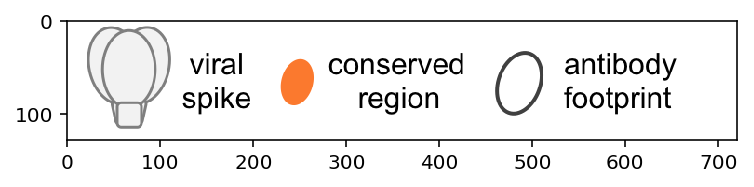

In [25]:
keySchem = mpimg.imread('figures/legend.png')
imgplot  = plot.imshow(keySchem[160:])

In [69]:
print(single_column, one_five_column, double_column)


3.3464566929133857 4.488188976377953 6.850393700787401


### Old plot format

In [ ]:
nTrials  = 10000
reload(mp)

# w     = double_column
# goldh = (2.8*w)/3.
# fig   = plot.figure(figsize=(w, goldh))

# HiBox = [0.22, 0.98, 0.52, 0.90]
# LoBox = [0.22, 0.98, 0.02, 0.40]

# w     = one_five_column
# goldh = (2.8*w)/3.
# fig   = plot.figure(figsize=(w, goldh))

# HiBox = [0.22, 0.98, 0.53, 0.93]
# LoBox = [0.22, 0.98, 0.00, 0.40]

w     = double_column
goldh = (2.0/3.0)*w
fig   = plot.figure(figsize=(w, goldh))

LoBox = [0.20, 0.72, 0.53, 0.93]
HiBox = [0.20, 0.72, 0.00, 0.40]
LLBox = [0.82, 0.98, 0.68, 0.93]

gsS   = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsS.update(left=HiBox[0], right=HiBox[1], bottom=0.95, top=0.99)
gsHiS = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsHiS.update(left=0.02, right=0.12, bottom=HiBox[2]+((HiBox[3]-HiBox[2])*0.5/1.3), top=HiBox[3])
gsLoS = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0])
gsLoS.update(left=0.02, right=0.12, bottom=LoBox[2]+((LoBox[3]-LoBox[2])*0.5/1.3), top=LoBox[3])
axS   = [plot.subplot(gsS[ 0, 0]), plot.subplot(gsHiS[ 0, 0]), plot.subplot(gsLoS[ 0, 0])]

gsHi  = gridspec.GridSpec(2, 3, height_ratios=[1.0, 0.3], width_ratios=[1.0, 1.0, 1.0])
gsHi.update(left=HiBox[0], right=HiBox[1], bottom=HiBox[2], top=HiBox[3], hspace=0.4, wspace=0.1)
gsLo  = gridspec.GridSpec(2, 3, height_ratios=[1.0, 0.3], width_ratios=[1.0, 1.0, 1.0])
gsLo.update(left=LoBox[0], right=LoBox[1], bottom=LoBox[2], top=LoBox[3], hspace=0.4, wspace=0.1)
axHi  = [[plot.subplot(gsHi[0, i]), plot.subplot(gsHi[1, i])] for i in range(len(genCut))]
axLo  = [[plot.subplot(gsLo[0, i]), plot.subplot(gsLo[1, i])] for i in range(len(genCut))]

gsLL = gridspec.GridSpec(1, 1, height_ratios=[1.0], width_ratios=[1.0])
gsLL.update(left=LLBox[0], right=LLBox[1], bottom=LLBox[2], top=LLBox[3], hspace=0.4, wspace=0.1)
axLL = [plot.subplot(gsLL[0, 0])]

# Overhead line

lineprops = { 'lw' : axwidth/2., 'ls' : '-', 'alpha' : 1.0 }
pprops    = { 'xlim' : [0, 1], 'xticks' : [], 'ylim' : [0, 1], 'yticks' : [], 
              'hide' : ['top','bottom','left','right'], 'plotprops' : lineprops }
axS[0].text(1./6.-0.020, 0.2,      r'$25$', ha='center', va='center', color=bkcolor, family=fontfamily, size=sizelabel)
axS[0].text(3./6.-0.005, 0.2,     r'$150$', ha='center', va='center', color=bkcolor, family=fontfamily, size=sizelabel)
axS[0].text(5./6.+0.015, 0.2,     r'$400$', ha='center', va='center', color=bkcolor, family=fontfamily, size=sizelabel)
axS[0].text(3./6.-0.005, 1.0, 'Generation', ha='center', va='center', color=bkcolor, family=fontfamily, size=sizelabel)
mp.plot(type='line', ax=axS[0], x=[[0,1]], y=[[0,0]], colors=[bkcolor], **pprops)

# PART 1: densities

print('Plotting densities...')

legendprops  = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                 'prop' : {'size' : sizelabel}, 'ncol' : 1 }
contourprops = { 'cmap' : 'Oranges', 'colors' : bkcolor, 'vmin' : 0.001, 'vmax' : 0.10, 'extend' : 'max',
                 'linewidths' : sizeline/2., 'levels' : [0.001, 0.005, 0.015, 0.035, 0.075, 0.15]}

dx     = 0.1
dy     = dx * (1. / 16.)
cx     = np.arange(0., 16.+dx, dx)
cy     = np.arange(0.,  1.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.5
sy = sx * (1. / 16.)
    
pprops = { 'xlim'      : [ 0., 16.],
           'xticks'    : [ 0.,  4.,  8., 12., 16.],
           'xticklabels' : [r'$0$', r'$-4$', r'$-8$', r'$-12$', r'$-16$'],
           'ylim'      : [ 0., 1.],
           'yticks'    : [ 0., 0.25, 0.50, 0.75, 1.00],
           'xlabel'    : r'$E_c$',
           'ylabel'    : r'$Q$',
           'plotprops' : contourprops,
           'zorder'    : 10 }

for i in range(len(genCut)):
    tempprops = pprops.copy()
    if i>0:
        del tempprops['ylabel']
        tempprops['yticks']   = []
        tempprops['hide']     = ['left']
    zz = np.zeros(xx.shape)
    for k in range(len(xHi[i])):
        zz += np.exp(-((xHi[i][k]-xx)**2/sx**2) - ((yHi[i][k]-yy)**2/sy**2))
    zz /= float(len(xHi[i]))
    mp.plot(type='contour', ax=axHi[i][0], x=[xx], y=[yy], z=[zz], **tempprops)

for i in range(len(genCut)):
    tempprops = pprops.copy()
    if i>0:
        del tempprops['ylabel']
        tempprops['yticks']   = []
        tempprops['hide']     = ['left']
    zz = np.zeros(xx.shape)
    for k in range(len(xLo[i])):
        zz += np.exp(-((xLo[i][k]-xx)**2/sx**2) - ((yLo[i][k]-yy)**2/sy**2))
    zz /= float(len(xLo[i]))
    mp.plot(type='contour', ax=axLo[i][0], x=[xx], y=[yy], z=[zz], **tempprops)

# PART 2: breadth

print('Plotting breadth...')

legendprops = { 'loc' : 4, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : 0.1, 
                'prop' : {'size' : sizelabel}, 'ncol' : 1 }
lineprops   = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 1.0 }
cHist       = '#3182bd'

histprops = { 'histtype' : 'bar', 'lw' : sizeline/2, 'rwidth' : 0.8, 'ls' : 'solid', 'alpha' : 0.7 }

pprops = { 'xlim'        : [ 0., 14.],
           'xticks'      : [ 0.,  4., 8., 12.],
           'xticklabels' : [r'$0$', r'$-4$', r'$-8$', r'$-12$'],
           'ylim'        : [ 0., 0.50],
           'yticks'      : [ 0., 0.25, 0.50],
           'yticklabels' : [  0,   25,   50],
           'xlabel'      : 'Median binding free energy',
           'ylabel'      : 'Frequency (%)',
           'plotprops'   : histprops,
           'bins'        : np.arange(0.0, 14.5, 0.5),
           'combine'     : True }

for g in range(len(genCut)):
    tempprops = pprops.copy()
    if g>0: 
        del tempprops['ylabel']
        tempprops['yticks'] = []
        tempprops['hide']   = ['left']
    mp.plot(type='hist', ax=axHi[g][1], x=[bHiMed[g]], colors=[cHist], **tempprops)
    mp.plot(type='hist', ax=axLo[g][1], x=[bLoMed[g]], colors=[cHist], **tempprops)
    
# PART 3: Q vs breadth

print('Plotting Q vs breadth...')

dx     = 0.05
dy     = dx * (1. / 7.)
cx     = np.arange(3., 10.+dx, dx)
cy     = np.arange(0.,  1.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.4
sy = sx * (1. / 7.)

zz = np.zeros(xx.shape)
for k in range(len(bLoMed[-1])):
    zz += np.exp(-((bLoMed[-1][k]-xx)**2/sx**2) - ((yLo[-1][k]-yy)**2/sy**2))
zz /= float(len(bLoMed[-1]))

contourprops['cmap'] = 'Blues'
scatterprops = { 'lw' : 0, 's' : 8., 'marker' : 'o' }

pprops = { 'xlim'      : [ 3., 10.],
           'xticks'    : [ 4., 6., 8., 10.],
           'xticklabels' : [r'$-4$', r'$-6$', r'$-8$', r'$-10$'],
           'xaxstart'  : 3,
           'ylim'      : [ 0., 1.],
           'yticks'    : [ 0., 0.25, 0.50, 0.75, 1.00],
           'xlabel'    : 'Median binding free energy',
           'ylabel'    : r'$Q$',
           'plotprops' : contourprops,
           #'plotprops' : scatterprops,
           'zorder'    : 10 }

mp.plot(type='contour', ax=axLL[0], x=[xx], y=[yy], z=[zz], **pprops)
#mp.plot(type='scatter', ax=axLL[0], x=[bLoMed[-1]], y=[yLo[-1]], colors=[cHist], **pprops)
    
# Schematic

hiSchem = mpimg.imread('figures/hiEc.png')
loSchem = mpimg.imread('figures/loEc.png')
axS[1].imshow(hiSchem)
axS[2].imshow(loSchem)
for a in ['left', 'right', 'bottom', 'top']: 
    axS[1].spines[a].set_visible(False)
    axS[2].spines[a].set_visible(False)
axS[1].set_xticks([])
axS[1].set_yticks([])
axS[2].set_xticks([])
axS[2].set_yticks([])
axS[2].text( 0.02, LoBox[3]-0.01, 'A', transform=fig.transFigure, **def_sublabelprops)
axLL[0].text(0.76, LoBox[3]-0.01, 'B', transform=fig.transFigure, **def_sublabelprops)
axS[1].text( 0.02, HiBox[3]-0.01, 'C', transform=fig.transFigure, **def_sublabelprops)
axS[1].text(0.07, (HiBox[2]+HiBox[3])/2.-0.03, 'Strong initial ' + r'$E_c$', ha='center', va='center',
            transform=fig.transFigure, **def_labelprops)
axS[2].text(0.07, (LoBox[2]+LoBox[3])/2.-0.03, 'Weak initial ' + r'$E_c$', ha='center', va='center', 
            transform=fig.transFigure, **def_labelprops)

# Background

cBG   = '#F5F5F5'
dy    = 0.07
bgHi  = axS[1].axis()
recHi = matplotlib.patches.Rectangle(xy=(0,HiBox[2]-1.3*dy), width=0.74, height=HiBox[3]-HiBox[2]+(1.5*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recHi = axS[1].add_patch(recHi)

bgLo  = axS[2].axis()
recLo = matplotlib.patches.Rectangle(xy=(0,LoBox[2]-1.3*dy), width=0.74, height=LoBox[3]-LoBox[2]+(1.5*dy), 
                                     transform=fig.transFigure, ec=None, fc=cBG, clip_on=False, zorder=-100)
recLo = axS[2].add_patch(recLo)
    
# Save data
plot.savefig('figures/l0.8-contour-breadth-Ec-Q.pdf', dpi = 1000, 
              facecolor = fig.get_facecolor(), edgecolor=None, **figprops)
plot.close(fig)
print('Done.')


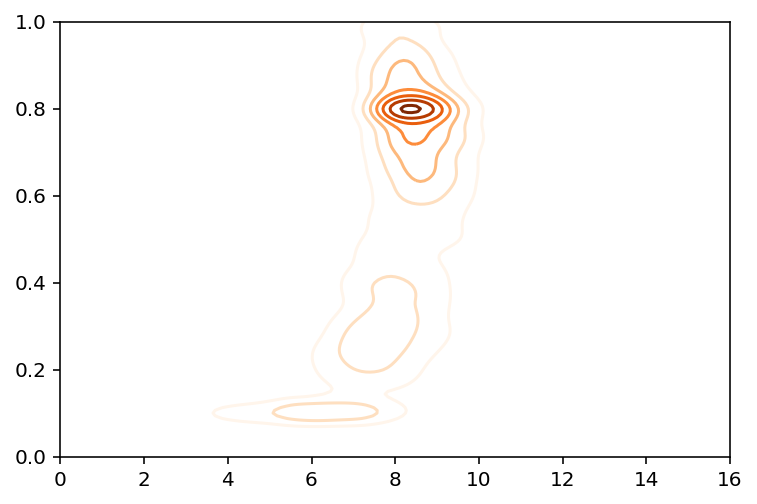

In [46]:
contourprops = { 'cmap' : 'Oranges' }

dx     = 0.1
dy     = dx * (1. / 16.)
cx     = np.arange(0., 16.+dx, dx)
cy     = np.arange(0.,  1.+dy, dy)
xx, yy = np.meshgrid(cx, cy)

sx = 0.5
sy = sx * (1. / 16.)

zz = np.zeros(xx.shape)
for k in range(len(xLo[2])):
    zz += np.exp(-((xLo[2][k]-xx)**2/sx**2) - ((yLo[2][k]-yy)**2/sy**2))
    
plot.figure()
plot.subplot(111)
plot.contour(xx, yy, zz, **contourprops)
plot.show()